In [119]:
import pandas as pd
import os
import matplotlib.pyplot as plt
file_path = os.path.join(os.getcwd(),  "data", "data.xlsx")
data = pd.read_excel(file_path, sheet_name="Target", skiprows=1)
data.index = pd.to_datetime(data.dt)
data = data.resample('MS').last()
#data=data.drop(columns='dt')
data.columns=['dt']+[i_fam.split('VENTA_')[1] for i_fam in list(data.columns)[1::]]
fam=list(data.columns)[1:-1]

In [120]:
def plot_families(df, x_column, ylabel, xlabel, title):
    x = df[x_column]
    families = df.drop(columns=[x_column])
    plt.figure(figsize=(20, 10))
    for family in families.columns:
        plt.plot(x, families[family], label=family, linestyle='--', alpha=0.8)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(0, 50000)
    plt.title(title)
    plt.legend(title="Familias de Productos", loc='upper right', fontsize='small', ncol=2)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

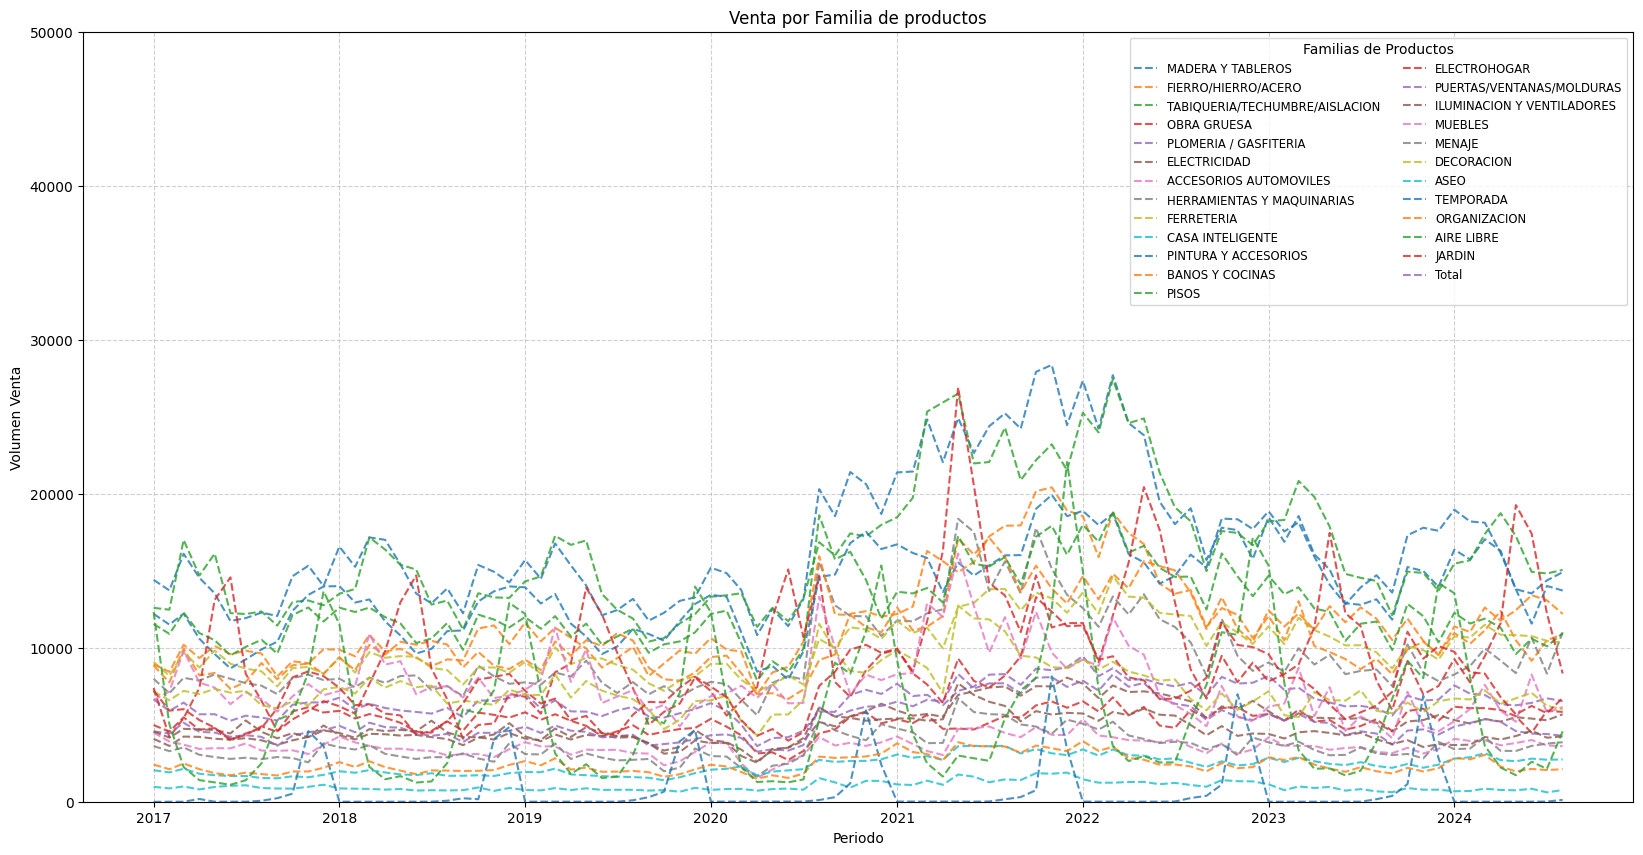

In [122]:
plot_families(data, "dt", 'Volumen Venta', "Periodo", "Venta por Familia de productos")

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_functional_analysis(data, time_column, columns_to_plot, ylabel, xlabel, title):
    time = data[time_column]
    curves = data[columns_to_plot]
    mean_curve = curves.mean(axis=1)
    std_curve = curves.std(axis=1)
    plt.figure(figsize=(20, 10))
    for col in columns_to_plot:
        plt.plot(time, data[col], linestyle='--', alpha=0.6, label=col)
    plt.plot(time, mean_curve, color='black', linewidth=2, label="Media")
    plt.fill_between(time, mean_curve - std_curve, mean_curve + std_curve, color='gray', alpha=0.3, label="Banda de Confianza (1 STD)")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(  loc="center left",  fontsize='small', title="Curvas Individuales")
    plt.grid(alpha=0.3)
    plt.show()



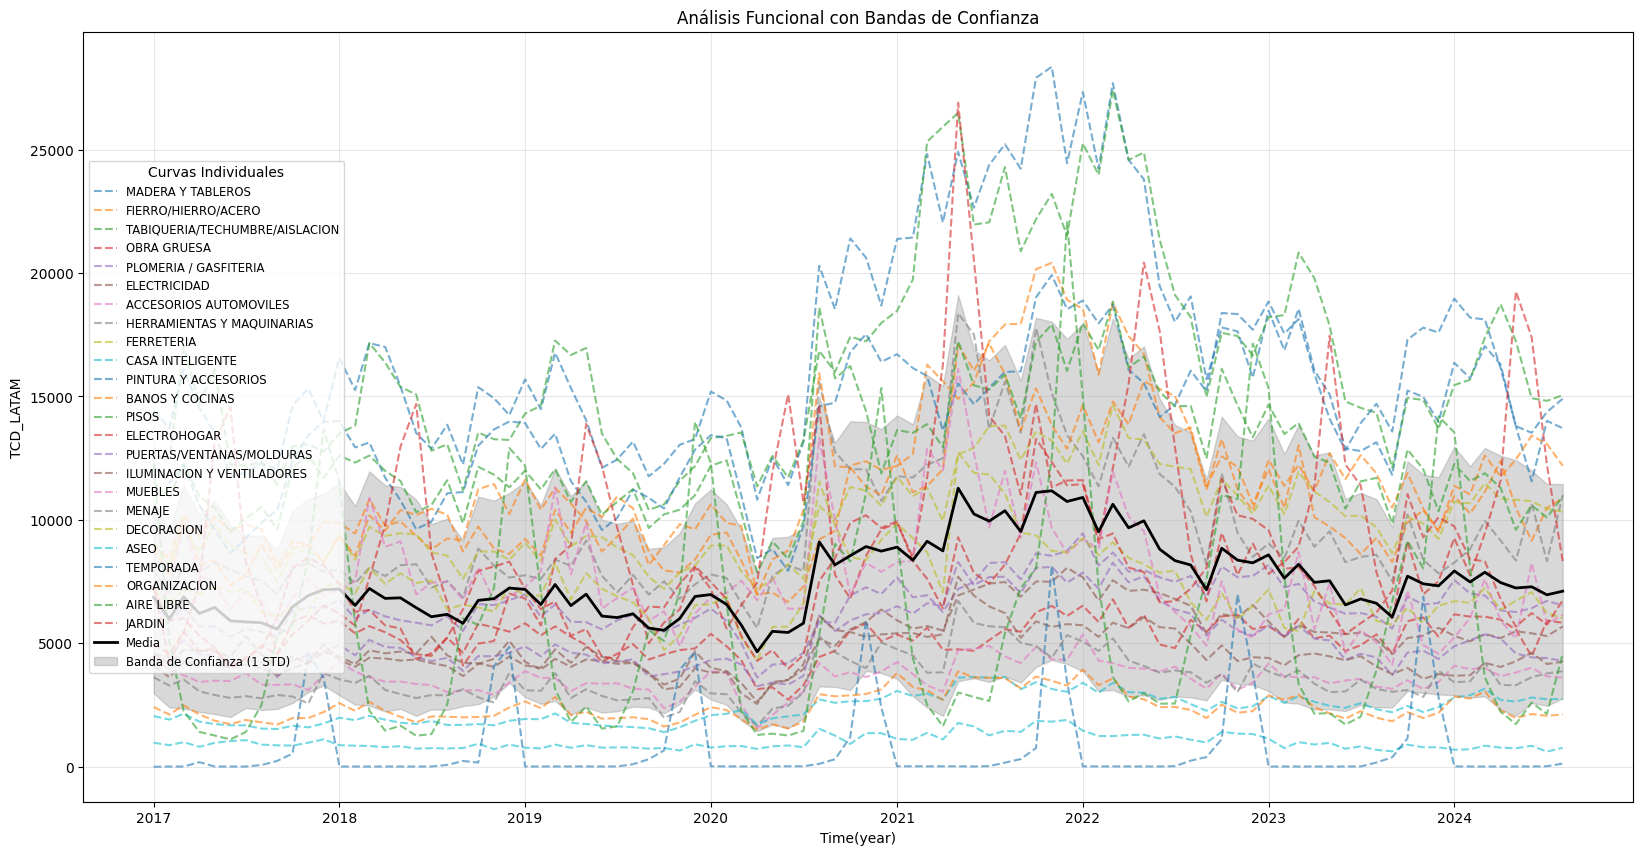

In [126]:
    plot_functional_analysis(
        data=data,
        time_column="dt",
        columns_to_plot=fam,
        ylabel="TCD_LATAM",
        xlabel="Time(year)",
        title="Análisis Funcional con Bandas de Confianza"
    )


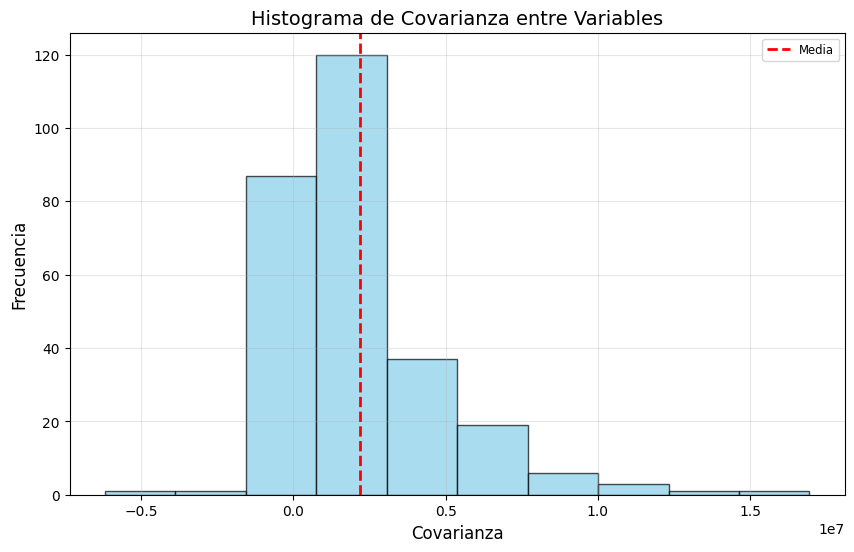

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def covariance_histogram_with_table(data, columns_to_plot, bins=10, title="Histograma de Covarianza"):
    cov_matrix = data[columns_to_plot].cov()
    cov_values = cov_matrix.values[np.triu_indices_from(cov_matrix, k=1)]
    plt.figure(figsize=(10, 6))
    counts, edges, _ = plt.hist(cov_values, bins=bins, color="skyblue", edgecolor="black", alpha=0.7)
    plt.title(title, fontsize=14)
    plt.xlabel("Covarianza", fontsize=12)
    plt.ylabel("Frecuencia", fontsize=12)
    plt.axvline(np.mean(cov_values), color="red", linestyle="dashed", linewidth=2, label="Media")
    plt.legend(loc="upper right", fontsize="small")
    plt.grid(alpha=0.3)
    plt.show()
    bin_edges = pd.IntervalIndex.from_breaks(edges, closed='left')
    freq_table = pd.DataFrame({
        "Lower": edges[:-1],
        "Upper": edges[1:],
        "Main": (edges[:-1] + edges[1:]) / 2,
        "Frequency": counts.astype(int)
    })
    freq_table["Percentage"] = freq_table["Frequency"] / freq_table["Frequency"].sum() * 100
    freq_table["CF"] = freq_table["Frequency"].cumsum()
    freq_table["CPF"] = freq_table["CF"] / freq_table["Frequency"].sum() * 100
    return freq_table


# Llamar a la función
tabla_frecuencias = covariance_histogram_with_table(
    data=data,
    columns_to_plot=fam,
    bins=10,
    title="Histograma de Covarianza entre Variables"
)


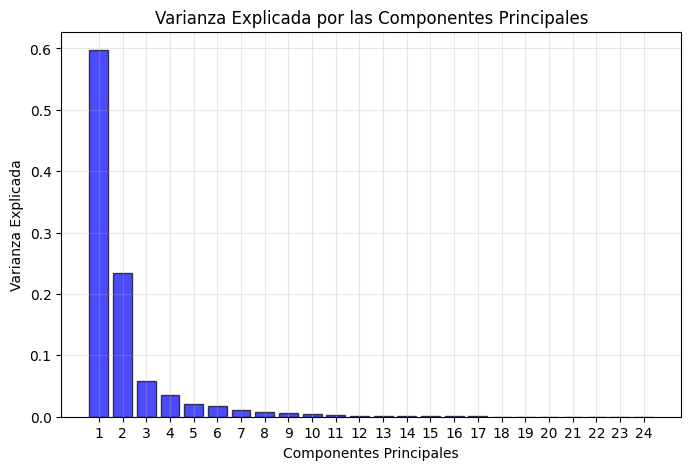

Varianza explicada: [0.6  0.23 0.06 0.04 0.02 0.02 0.01 0.01 0.01 0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]


In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_explained_variance(data, columns_to_plot, title="Varianza Explicada con PCA"):
    features = data[columns_to_plot].values
    pca = PCA()
    pca.fit(features)
    explained_variance_ratio = pca.explained_variance_ratio_
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, color="blue", alpha=0.7, edgecolor="black")
    plt.xticks(range(1, len(explained_variance_ratio) + 1))
    plt.xlabel("Componentes Principales")
    plt.ylabel("Varianza Explicada")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.show()
    return explained_variance_ratio
varianza = plot_explained_variance(
    data=data,
    columns_to_plot=fam,
    title="Varianza Explicada por las Componentes Principales"
)

print("Varianza explicada:", np.round(varianza,2))

In [130]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

def get_pca_scores(data, columns_to_plot, n_components=2):
    features = data[columns_to_plot]
    pca = PCA(n_components=n_components)
    pca_scores = pca.fit_transform(features)
    pca_scores_df = pd.DataFrame(
        pca_scores,
        columns=[f"PC{i+1}" for i in range(n_components)],
        index=data.index
    )
    if "Familia" in data.columns:
        pca_scores_df["Familia"] = data["Familia"]
    return pca_scores_df

pca_scores = get_pca_scores(data, columns_to_plot=fam)

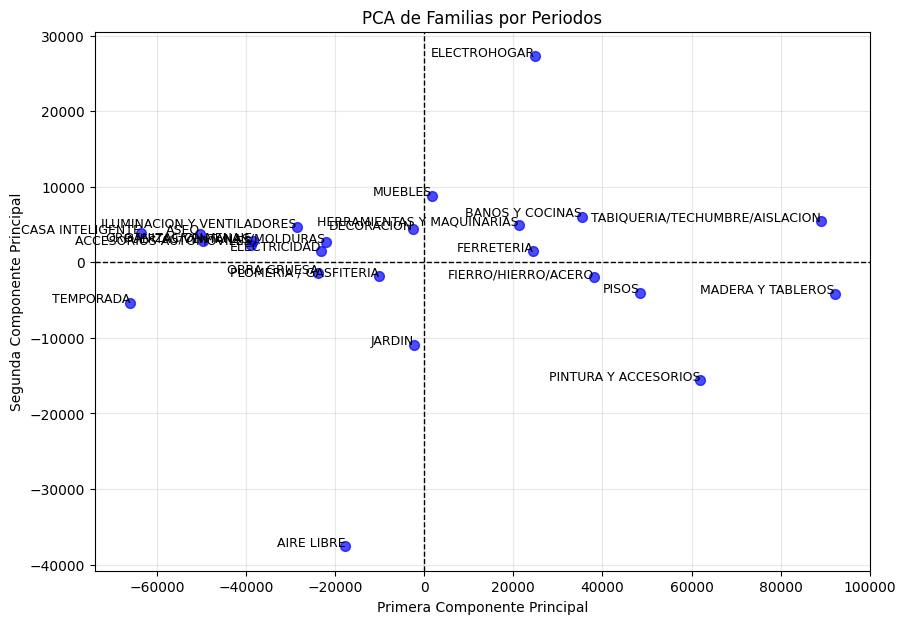

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_pca_with_families(data, period_column, family_columns, title="PCA de Familias por Periodos"):
    features = data[family_columns].T.values  # Transponer para que las familias sean las filas
    families = family_columns
    pca = PCA(n_components=2)
    pca_scores = pca.fit_transform(features)
    plt.figure(figsize=(10, 7))
    plt.scatter(pca_scores[:, 0], pca_scores[:, 1], c='blue', alpha=0.7, s=50)
    for i, family in enumerate(families):
        plt.text(pca_scores[i, 0], pca_scores[i, 1], family, fontsize=9, ha='right')
    plt.axhline(0, color="black", linestyle="dashed", linewidth=1)
    plt.axvline(0, color="black", linestyle="dashed", linewidth=1)
    plt.xlabel("Primera Componente Principal")
    plt.ylabel("Segunda Componente Principal")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.show()

plot_pca_with_families(
    data=data,
    period_column="Periodo",
    family_columns=fam,
    title="PCA de Familias por Periodos"
)

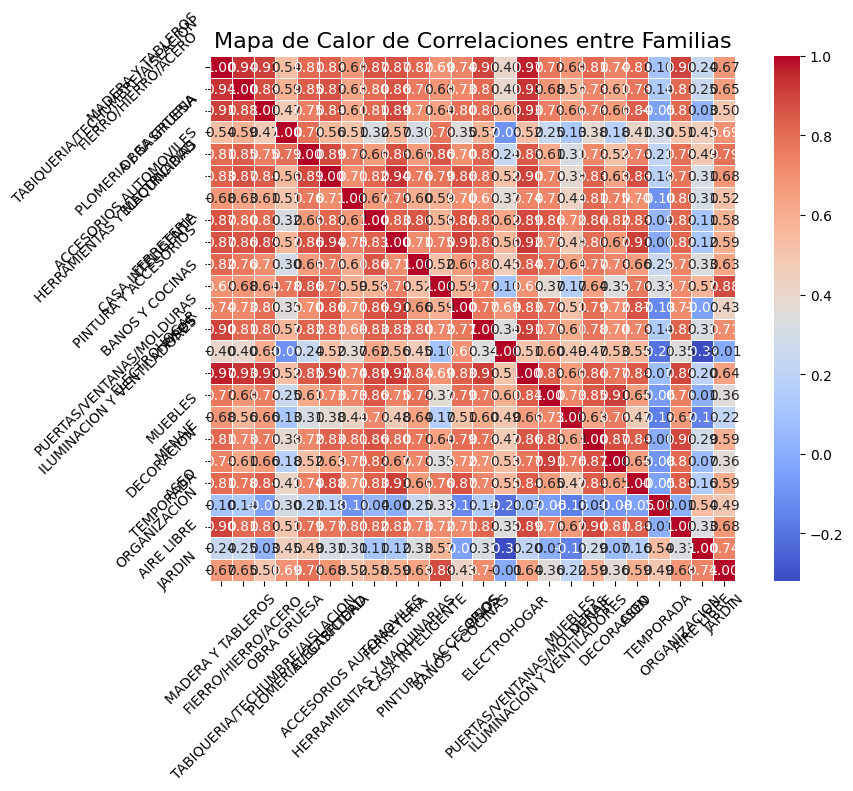

In [132]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_custom_correlation_heatmap(data, columns_to_plot, title="Mapa de Calor de Correlaciones"):
    corr_matrix = data[columns_to_plot].corr()
    plt.figure(figsize=(13003, 10303), dpi=300)
    sns.heatmap(
        corr_matrix, 
        annot=True, 
        fmt=".2f", 
        cmap="coolwarm", 
        cbar=True, 
        vmin=-1, vmax=1, 
        square=True, 
        linewidths=0.5,
        annot_kws={"size":1}  
    )
    plt.title(title, fontsize=2)  # Tamaño del título
    plt.xticks(rotation=0, fontsize=2)  # Tamaño y rotación de etiquetas del eje x
    plt.yticks(rotation=0, fontsize=2)  # Tamaño y rotación de etiquetas del eje y
    plt.tight_layout()
    plt.show()

plot_correlation_heatmap(
    data=data,
    columns_to_plot=fam,
    title="Mapa de Calor de Correlaciones entre Familias"
)

In [133]:
import pandas as pd
import numpy as np

def find_important_covariances(data, columns_to_analyze, top_n=5):
    cov_matrix = data[columns_to_analyze].cov()
    cov_pairs = []
    for i in range(len(cov_matrix.columns)):
        for j in range(i + 1, len(cov_matrix.columns)):
            cov_pairs.append((cov_matrix.columns[i], cov_matrix.columns[j], cov_matrix.iloc[i, j]))
    cov_df = pd.DataFrame(cov_pairs, columns=["Variable 1", "Variable 2", "Covarianza"])
    cov_df["Abs_Covarianza"] = cov_df["Covarianza"].abs()
    cov_df = cov_df.sort_values(by="Abs_Covarianza", ascending=False)
    return cov_df.head(top_n)

important_covariances = find_important_covariances(data, fam, top_n=5)

In [134]:
important_covariances

,Variable 1,Variable 2,Covarianza,Abs_Covarianza
1,MADERA Y TABLEROS,TABIQUERIA/TECHUMBRE/AISLACION,1.694876e+07,1.694876e+07
0,MADERA Y TABLEROS,FIERRO/HIERRO/ACERO,1.342831e+07,1.342831e+07
23,FIERRO/HIERRO/ACERO,TABIQUERIA/TECHUMBRE/AISLACION,1.176120e+07,1.176120e+07
55,TABIQUERIA/TECHUMBRE/AISLACION,ELECTROHOGAR,1.046922e+07,1.046922e+07
6,MADERA Y TABLEROS,HERRAMIENTAS Y MAQUINARIAS,1.043387e+07,1.043387e+07


In [135]:
import pandas as pd
import numpy as np

def find_cross_selling_families(data, family_columns, threshold=0.7):
    cov_matrix = data[family_columns].cov()
    cov_pairs = []
    for i in range(len(cov_matrix.columns)):
        for j in range(i + 1, len(cov_matrix.columns)):
            if cov_matrix.iloc[i, j] > threshold:  # Umbral para identificar relaciones fuertes
                cov_pairs.append((cov_matrix.columns[i], cov_matrix.columns[j], cov_matrix.iloc[i, j]))
    cov_df = pd.DataFrame(cov_pairs, columns=["Familia 1", "Familia 2", "Covarianza"])
    return cov_df

cross_selling_families = find_cross_selling_families(data,fam, threshold=500)


In [136]:
cross_selling_families

,Familia 1,Familia 2,Covarianza
0,MADERA Y TABLEROS,FIERRO/HIERRO/ACERO,1.342831e+07
1,MADERA Y TABLEROS,TABIQUERIA/TECHUMBRE/AISLACION,1.694876e+07
2,MADERA Y TABLEROS,OBRA GRUESA,1.816162e+06
3,MADERA Y TABLEROS,PLOMERIA / GASFITERIA,3.844453e+06
4,MADERA Y TABLEROS,ELECTRICIDAD,4.630968e+06
...,...,...,...
258,TEMPORADA,AIRE LIBRE,4.505211e+06
259,TEMPORADA,JARDIN,1.793708e+06
260,ORGANIZACION,AIRE LIBRE,8.863021e+05
261,ORGANIZACION,JARDIN,8.144082e+05


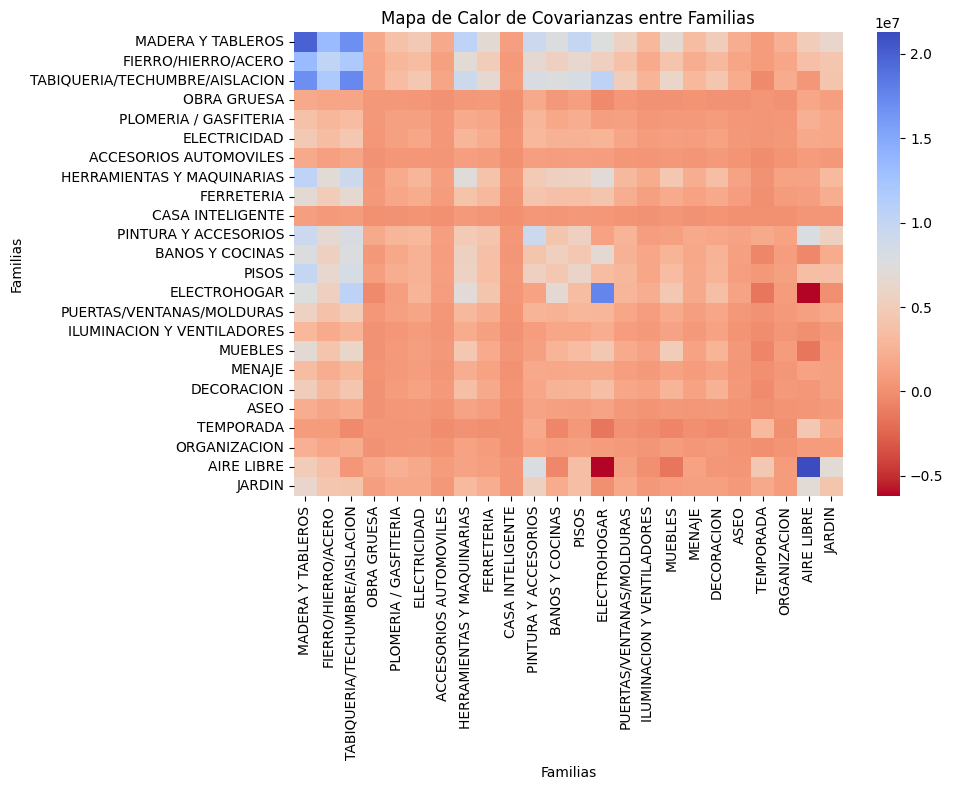

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap_covariance(data, columns_to_plot):
    cov_matrix = data[columns_to_plot].cov()  # Calcular la matriz de covarianza
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cov_matrix, 
        annot=False,  # No mostrar números en las celdas
        fmt=".2e", 
        cmap="coolwarm_r",  # Paleta invertida: rojo en valores bajos, azul en altos
        cbar=True
    )
    plt.title("Mapa de Calor de Covarianzas entre Familias")
    plt.xlabel("Familias")
    plt.ylabel("Familias")
    plt.xticks(rotation=90)  # Rotar texto del eje X a 90 grados
    plt.tight_layout()
    plt.show()

plot_heatmap_covariance(data, fam)

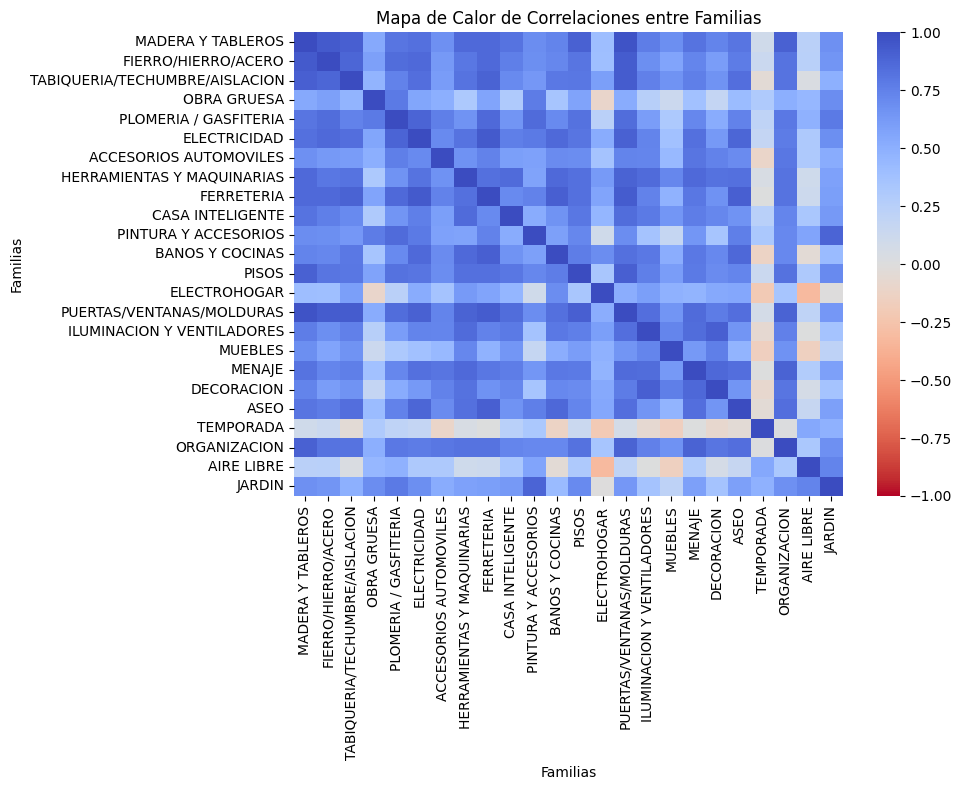

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap_correlation(data, columns_to_plot):
    corr_matrix = data[columns_to_plot].corr()  # Calcular la matriz de correlación
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr_matrix, 
        annot=False,  # No mostrar números en las celdas
        cmap="coolwarm_r",  # Paleta invertida: rojo en -1, azul en 1
        cbar=True, 
        vmin=-1, vmax=1  # Escala de correlación
    )
    plt.title("Mapa de Calor de Correlaciones entre Familias")
    plt.xlabel("Familias")
    plt.ylabel("Familias")
    plt.xticks(rotation=90)  # Rotar texto del eje X a 90 grados
    plt.tight_layout()
    plt.show()

plot_heatmap_correlation(data, fam)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_lsq_spline, BSpline

def plot_bsspline_ventas(data, tiempo_col, venta_cols, num_nodos=6, grado=3):
    # Obtener los valores de tiempo
    tiempo = data[tiempo_col].values
    
    # Crear los nodos uniformemente espaciados
    nodos = np.linspace(tiempo.min(), tiempo.max(), num_nodos)
    
    plt.figure(figsize=(12, len(venta_cols) * 4))
    
    for i, col in enumerate(venta_cols):
        # Obtener las ventas de la columna actual
        ventas = data[col].values
        
        # Ajustar la B-spline
        spline = make_lsq_spline(tiempo, ventas, nodos, k=grado)
        ventas_spline = spline(tiempo)  # Evaluar la spline en los puntos de tiempo
        
        # Graficar
        plt.subplot(len(venta_cols), 1, i + 1)
        plt.plot(tiempo, ventas, 'o', label=f'Datos originales ({col})', alpha=0.7)
        plt.plot(tiempo, ventas_spline, label=f'B-spline ajustada ({col})', linewidth=2)
        plt.title(f'Ajuste de B-spline para {col}')
        plt.xlabel('Tiempo')
        plt.ylabel('Ventas')
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_bsspline_ventas(data, tiempo_col="Tiempo", venta_cols=fam)

In [145]:
average_sales = data[fam].mean(axis=0).sort_values(ascending=False)
print("Familias con mayor promedio de ventas:")
print(average_sales.head())

Familias con mayor promedio de ventas:
MADERA Y TABLEROS                 16735.819290
TABIQUERIA/TECHUMBRE/AISLACION    16440.704242
PINTURA Y ACCESORIOS              14027.615257
PISOS                             12541.098942
FIERRO/HIERRO/ACERO               11262.558813
dtype: float64


In [148]:
# Calcular la matriz de correlación
correlation_matrix = data.drop(columns=['Total']).corr()

# Mostrar las correlaciones con las familias líderes
top_families = average_sales.head(3).index  # Seleccionar las 3 familias con mayor venta
for family in top_families:
    correlations = correlation_matrix[family].sort_values(ascending=False)
    print(f"\nCorrelaciones de {family}:")
    print(correlations.head(7))  # Mostrar las 5 familias más correlacionadas


Correlaciones de MADERA Y TABLEROS:
MADERA Y TABLEROS                 1.000000
PUERTAS/VENTANAS/MOLDURAS         0.968424
FIERRO/HIERRO/ACERO               0.937126
TABIQUERIA/TECHUMBRE/AISLACION    0.910422
ORGANIZACION                      0.904371
PISOS                             0.903426
FERRETERIA                        0.865967
Name: MADERA Y TABLEROS, dtype: float64

Correlaciones de TABIQUERIA/TECHUMBRE/AISLACION:
TABIQUERIA/TECHUMBRE/AISLACION    1.000000
PUERTAS/VENTANAS/MOLDURAS         0.928296
MADERA Y TABLEROS                 0.910422
FERRETERIA                        0.894166
FIERRO/HIERRO/ACERO               0.879307
ELECTRICIDAD                      0.842104
ASEO                              0.837588
Name: TABIQUERIA/TECHUMBRE/AISLACION, dtype: float64

Correlaciones de PINTURA Y ACCESORIOS:
PINTURA Y ACCESORIOS     1.000000
JARDIN                   0.883415
PLOMERIA / GASFITERIA    0.857475
ELECTRICIDAD             0.786956
OBRA GRUESA              0.776465
ASEO    

In [149]:

threshold = 0.7
cross_selling_candidates = {}
for family in top_families:
    correlated_families = correlation_matrix[family][correlation_matrix[family] > threshold].index.tolist()
    cross_selling_candidates[family] = correlated_families

print("\nCandidatos para estrategias de cross-selling:")
for leader, candidates in cross_selling_candidates.items():
    print(f"Familia líder: {leader}")
    print(f"Familias correlacionadas: {candidates}")


Candidatos para estrategias de cross-selling:
Familia líder: MADERA Y TABLEROS
Familias correlacionadas: ['MADERA Y TABLEROS', 'FIERRO/HIERRO/ACERO', 'TABIQUERIA/TECHUMBRE/AISLACION', 'PLOMERIA / GASFITERIA', 'ELECTRICIDAD', 'HERRAMIENTAS Y MAQUINARIAS', 'FERRETERIA', 'CASA INTELIGENTE', 'BANOS Y COCINAS', 'PISOS', 'PUERTAS/VENTANAS/MOLDURAS', 'ILUMINACION Y VENTILADORES', 'MENAJE', 'DECORACION', 'ASEO', 'ORGANIZACION']
Familia líder: TABIQUERIA/TECHUMBRE/AISLACION
Familias correlacionadas: ['MADERA Y TABLEROS', 'FIERRO/HIERRO/ACERO', 'TABIQUERIA/TECHUMBRE/AISLACION', 'PLOMERIA / GASFITERIA', 'ELECTRICIDAD', 'HERRAMIENTAS Y MAQUINARIAS', 'FERRETERIA', 'CASA INTELIGENTE', 'BANOS Y COCINAS', 'PISOS', 'PUERTAS/VENTANAS/MOLDURAS', 'ILUMINACION Y VENTILADORES', 'MENAJE', 'ASEO', 'ORGANIZACION']
Familia líder: PINTURA Y ACCESORIOS
Familias correlacionadas: ['OBRA GRUESA', 'PLOMERIA / GASFITERIA', 'ELECTRICIDAD', 'FERRETERIA', 'PINTURA Y ACCESORIOS', 'PISOS', 'ASEO', 'ORGANIZACION', 'JARDIN'

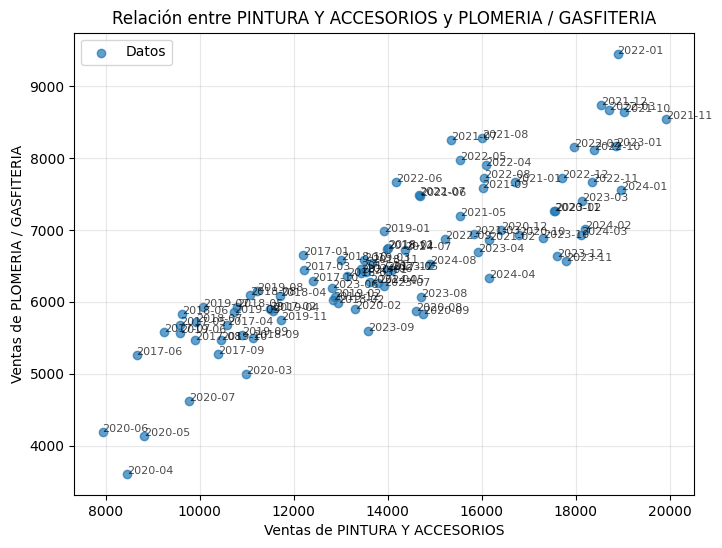

In [156]:
import matplotlib.pyplot as plt

def plot_labeled_relationship(data, family_leader, correlated_family):
    """
    Gráfico de dispersión etiquetado para mostrar la relación entre una familia líder y otra familia correlacionada.
    Las etiquetas se convierten al formato Año-Mes.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(data[family_leader], data[correlated_family], alpha=0.7, label="Datos")
    
    # Convertir el índice al formato Año-Mes (YYYY-MM)
    formatted_indices = data.index.strftime('%Y-%m')
    
    # Etiquetar cada punto con el índice en formato Año-Mes
    for i in range(len(data)):
        plt.text(data[family_leader].iloc[i], data[correlated_family].iloc[i], 
                 formatted_indices[i], fontsize=8, alpha=0.7)
    
    plt.title(f"Relación entre {family_leader} y {correlated_family}")
    plt.xlabel(f"Ventas de {family_leader}")
    plt.ylabel(f"Ventas de {correlated_family}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Llamar a la función
# plot_labeled_relationship(data, "Familia_Lider", "Familia_Correlacionada")
# Graficar un ejemplo
plot_labeled_relationship(data, top_families[2], cross_selling_candidates[top_families[2]][1])